# Turbidity in wetlands

* **Products used:** 
landsat_sr_kenya

## Background

In this notebook, we calculate turbidity in wetland areas through the Normalised Difference Turbidity Index (NDTI). Turbidity refers to the optical clarity of the water. While it is not strictly correlated with suspended matter, chlorophyll content, or other metrics, it is often used in conjunction to provide a more holistic analysis of water quality. 

NDTI is a band index defined as:

$\text{NDTI} = \frac{\text{Red} - \text{Green}}{\text{Red} + \text{Green}}$

[Lacaux et al, 2007](https://www.sciencedirect.com/science/article/abs/pii/S0034425706002811)

Here, we investigate NDTI over wetland areas in a several-year time series, through both a seasonal animation and a time series plot.

## Description
1. Load packages and connect to the datacube
2. Define area of interest and time range
3. Mask areas with water using WOfS
4. Plot and animate
5. Investigate wetlands extent over time

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [2]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
from IPython.display import Image
from geopandas import GeoDataFrame

from deafrica_tools.plotting import display_map, rgb, xr_animation, map_shapefile
from deafrica_tools.spatial import xr_vectorize, xr_rasterize
from deafrica_tools.datahandling import load_ard, mostcommon_crs, wofs_fuser
from deafrica_tools.bandindices import calculate_indices

### Connect to the datacube

In [3]:
dc = datacube.Datacube(app="Wetland_turbidity")

### Define area of interest

In [4]:
# Define the area of interest
lat = 0.046398
lon = 34.041865
lat_buffer = 0.2025
lon_buffer = 0.1025

# Time period
time_range = ("2017-01-01", "2021-12-31")

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

display_map(x=lon_range, y=lat_range)

## Load satellite data

The first step in the analysis is to load Landsat 8 data for the specified area of interest.
This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. 
The `load_ard` function is used here to load an analysis ready dataset free of shadow, and missing data.

Note that specifying the parameter `min_gooddata=0.9` reduces data from the middle of the year, when this area experiences maximum cloudy weather.

In [5]:
query = {
    "x": lon_range,
    "y": lat_range,
    "time": time_range,
    "resolution": (-30, 30),
    "align": (15, 15),
}

output_crs = mostcommon_crs(dc=dc, product='ls8_sr', query=query)
 
ds = load_ard(
    dc=dc,
    products=['ls8_sr', 'ls9_sr'],
    measurements=["red", "green", "blue", "nir"],
    group_by="solar_day",
    dask_chunks={"time": 1, "x": 2000, "y": 2000},
    output_crs=output_crs,
    min_gooddata=0.9,
    **query
)

/home/jovyan/.local/lib/python3.10/site-packages/deafrica_tools/datahandling.py:244: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
    ls9_sr
Counting good quality pixels for each time step
Filtering to 39 out of 114 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 39 time steps as a dask array


## Load WOfS

Values of NDTI are relative and the index should only be applied to water. Including land in the area of interest will skew the colourmap. All-time WOfS is used here to threshold for areas pixels which are likely to be water.

In [6]:
water = dc.load(
            product="wofs_ls_summary_alltime",
            like=ds.geobox,
            dask_chunks={"time": 1, "x": 2000, "y": 2000}
            )
#extract from mask the areas classified as water
water_extent = (water.frequency > 0.3).squeeze()

print(water_extent)

<xarray.DataArray 'frequency' (y: 1493, x: 761)>
dask.array<getitem, shape=(1493, 761), dtype=bool, chunksize=(1493, 761), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 2003-07-02T11:59:59.999999
  * y            (y) float64 2.751e+04 2.748e+04 ... -1.722e+04 -1.725e+04
  * x            (x) float64 6.045e+05 6.046e+05 ... 6.273e+05 6.273e+05
    spatial_ref  int32 32636


### Inspect water extent

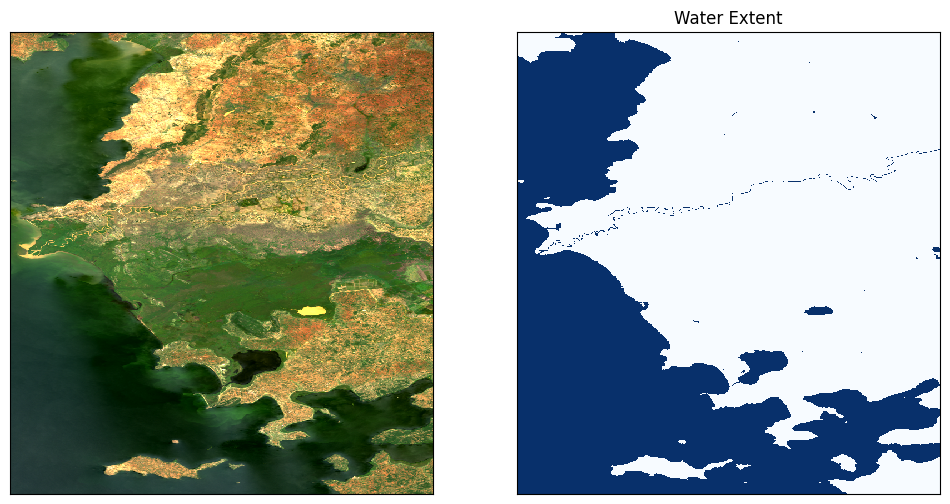

In [7]:
# Plot the geomedian composite and water extent
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

#plot the true colour image
rgb(ds.isel(time=5), ax=ax[0])

#plot the water extent from WOfS
water_extent.plot.imshow(ax=ax[1], cmap="Blues", add_colorbar=False)

# Titles
ax[0].set_title(""), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("Water Extent"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False);

## Plot NDTI

Here we calculate NDTI and add it to the loaded data set. It also generates an animation that is exported to the sandbox and can be saved by right-clicking the `.gif` and selecting "Download".

In [9]:
ds = calculate_indices(ds.where(water_extent), index="NDTI", satellite_mission="ls")

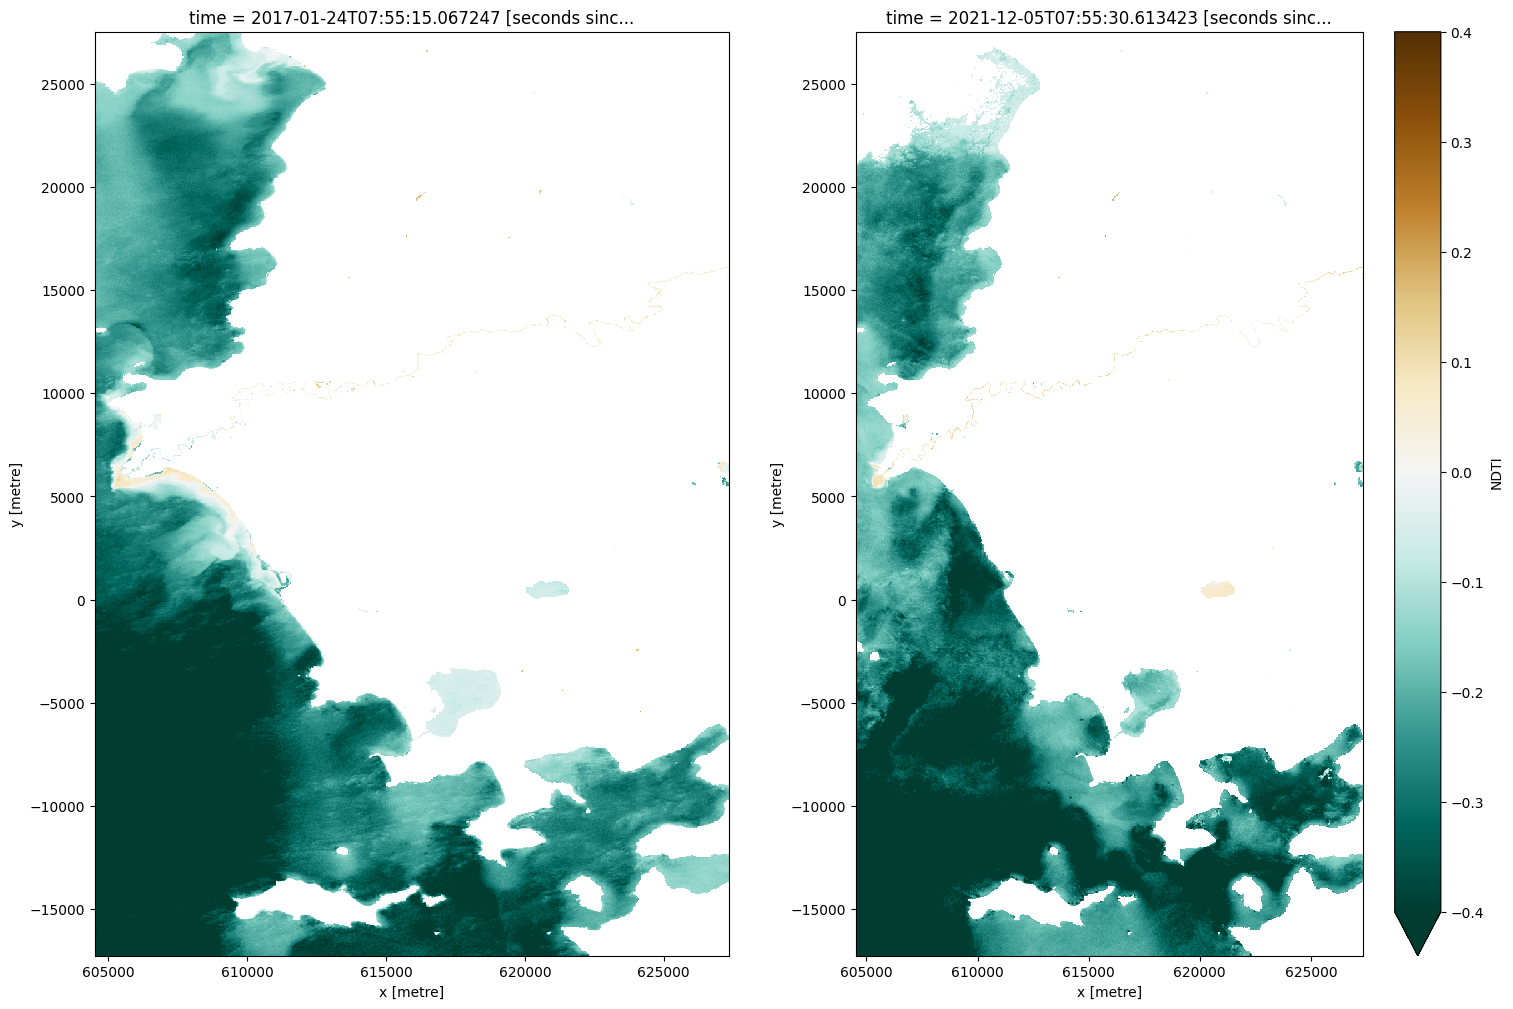

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
cmap='BrBG_r'
vmin=-0.4
vmax=0.4

ds.NDTI.isel(time=0).plot(ax=ax[0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
ds.NDTI.isel(time=-1).plot(ax=ax[1], cmap=cmap, add_colorbar=True, vmin=vmin, vmax=vmax);

Exporting animation to NDTI_2017-01-01_2021-12-31.gif


  0%|          | 0/39 (0.0 seconds remaining at ? frames/s)

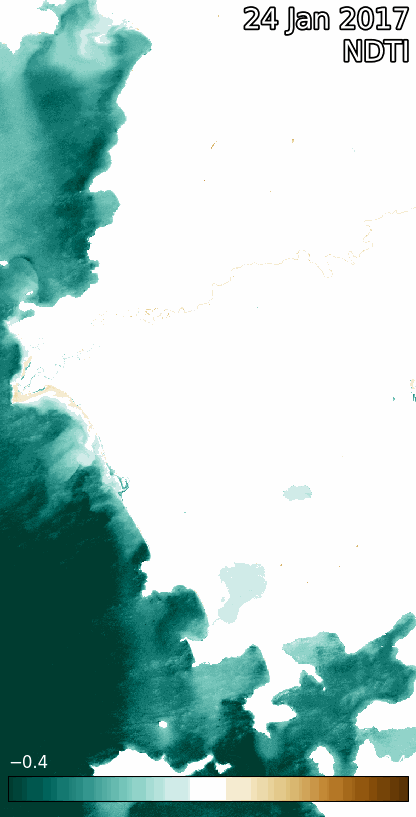

In [11]:
# Produce time series animation of NDTI
xr_animation(ds=ds, 
             output_path='NDTI_'+time_range[0]+'_'+time_range[1]+'.gif',
             bands=['NDTI'], 
             show_text='NDTI', 
             interval=250,
             imshow_kwargs={'cmap': 'BrBG_r', 'vmin': vmin, 'vmax': vmax},
             width_pixels=300) 

# Plot animated gif
plt.close()
Image(filename='NDTI_'+time_range[0]+'_'+time_range[1]+'.gif')

### Investigate size of waterbodies

The animated timeseries and plots above show a distinct difference in NDTI between large watercourses which generally appear blue-white, and smaller waterbodies which appear more orange to brown in the colour scheme. 

We might hypothesise that smaller waterbodies generally have higher NDTI values than larger ones, meaning they are more turbid. The histogram below suggests this might be the case as there are two peaks evident. We can test this further by splitting the the waterbodies by size below.

Text(0, 0.5, 'Count of pixels')

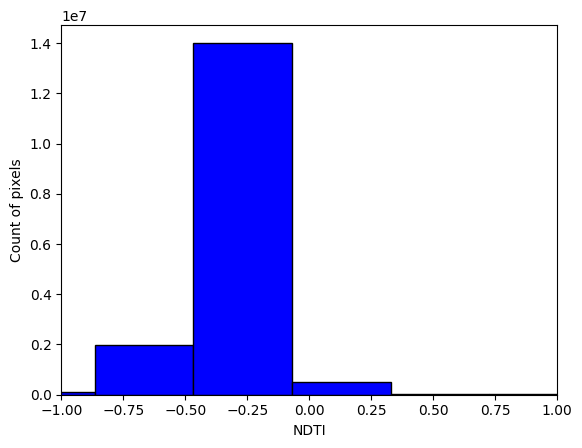

In [12]:
plt.hist(ds.NDTI.to_numpy().flatten(), color = 'blue', edgecolor = 'black',
         bins = 8000)
plt.xlim((-1,1))

# Add labels
plt.xlabel('NDTI')
plt.ylabel('Count of pixels')

### Vectorize waterbodies

We will split the waterbodies into two size classes, small and large, at a threshold of 50,000 square metres. You can adjust the threshold and test it in the plots below.

In [13]:
polygons = xr_vectorize(water_extent, crs='epsg:32628', mask=water_extent==True)
polygons['area'] = polygons.area
polygons['size'] = np.where(polygons['area']<50000, 1, 2) # se

The interactive plot below shows larger waterbodies in yellow and smaller ones in purple.

In [14]:
map_shapefile(polygons, attribute='size')

Label(value='')

Map(center=[0.04640525564163185, 34.04177700473166], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Here, we rasterize polygons and mask NDTI to small and large waterbodies, then calculate mean and standard deviation timeseries. This allows us to plot the timeseries in the cell below. The plot confirms that smaller waterbodies have higher NDTI values than larger ones, and the two size classes follow the same pattern over time.

In [15]:
water_size = xr_rasterize(gdf=polygons, da=water, attribute_col='size')

ds_large = ds.where(water_size==2)
ds_small = ds.where(water_size==1)

NDTI_ts_large = ds_large.NDTI.mean(['x','y'])
NDTI_ts_small = ds_small.NDTI.mean(['x','y'])
NDTI_ts_large_std = ds_large.NDTI.std(['x','y'])
NDTI_ts_small_std = ds_small.NDTI.std(['x','y'])

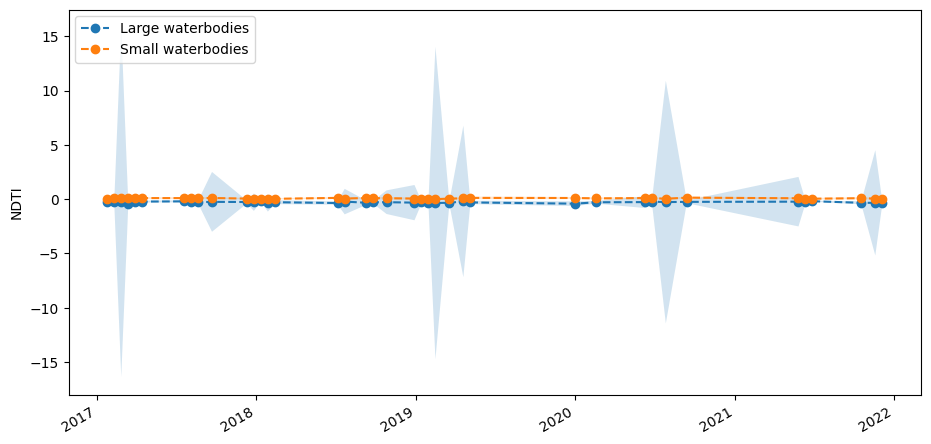

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
NDTI_ts_large.plot(ax=ax, label='Large waterbodies', linestyle='dashed', marker='o')
NDTI_ts_small.plot(ax=ax, label='Small waterbodies', linestyle='dashed', marker='o')
ax.fill_between(
    NDTI_ts_large.time,
    NDTI_ts_large-NDTI_ts_large_std,
    NDTI_ts_large+NDTI_ts_large_std,
    alpha=0.2,
)
ax.fill_between(
    NDTI_ts_small.time,
    NDTI_ts_small-NDTI_ts_small_std,
    NDTI_ts_small+NDTI_ts_small_std,
    alpha=0.2,
)
plt.legend(loc="upper left")
plt.title("")
plt.xlabel("");

Finally, we might hypothesise that the seasonal variation in turbidity seen above is related to rainfall. The plot of rainfall over the same time period, below, suggests this is the case. However, we would have to conduct further analysis to determine conditions that vary with turbidity.

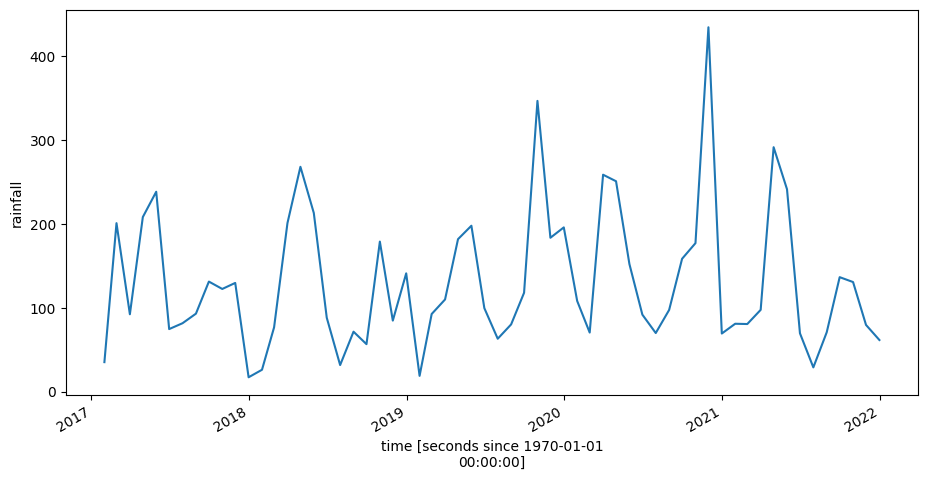

In [17]:
ds_rf_month = dc.load(product='rainfall_chirps_monthly',
                resolution=(-5000, 5000),
                output_crs='epsg:6933',
                x = lon_range,
                y = lat_range,
                time = time_range)

ds_rf_month.resample(time='1M').mean().rainfall.mean(['x','y']).plot(figsize=(11, 5))
plt.title("");